# Task 1, 2, 3:
## 1. completed, 
## 2. pending, 
## 3. finished but need to get opinion.

In [2]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import cv2

# output directory:  "../working/FILENAME"

'''
Direction
1. Load left/right images, Create np.array having same dimension, calling it as imgDisparity
2. Declare variables:
    searchWindowSize: also called BlockSize. it defines window size to calculate SSD between img1 and img2.
    maxDisparityRange: also called SearchBlockSize. it defines the rail searchWindow moves on. setup Max range.
3. Define functions: DisparitySSD:
    Might need another functions to find minimum SSD.
    args: img1, img2, searchWindow
    a. define searchWindowSize for applying to general use including edge/corner/boundary cases
    b. define disparityRange (index left and right) for same reason above.
       When doing this, disparity Index Left and right might be varying according to index (y, x), searchWindowSize.
    c. At each index (y,x) --> calculate SSD with index range (defined by c) in img2, which calculate SSDs (defined by b) 
    d. disparity value = y in img1 - y' (index found by SSD) --> Not sure calculate as is or additional operation like abs / square.
'''

def searchWindow(numRow, numCol, y, x, searchWindowSize):
    '''
    making general size confirm considering edge case
    args:
        numRow, numCol: shape of img1 array. they are boundary.
        y, x: row and column of img1
        X/Y searchWindowLength Left/Right/Top/Bottom: block length from center index (y, x) --> for edge cases
    '''
    ySearchWindowLengthTop = ySearchWindowLengthBottom = xSearchWindowLengthLeft = xSearchWindowLengthRight = searchWindowSize // 2
    
    if y - ySearchWindowLengthTop < 0:
        ySearchWindowLengthTop = y
    if y + ySearchWindowLengthBottom > numRow -1:
        ySearchWindowLengthBottom = numRow -1 -y
    if x - xSearchWindowLengthLeft < 0:
        xSearchWindowLengthLeft = x
    if x + xSearchWindowLengthRight > numCol -1:
        xSearchWindowLengthRight = numCol -1 -x
    return xSearchWindowLengthLeft, xSearchWindowLengthRight, ySearchWindowLengthTop, ySearchWindowLengthBottom
    

def disparityRangeCal(numRow, numCol, y, x, xSearchWindowLengthLeft, xSearchWindowLengthRight, disparityRange) -> (int, int):
    '''
    disparity calculation range according to each index
    args:
        numRow, numCol: shape of img1 array. they are boundary.
        y, x: row and column of img1
        disparityRange: adjusted odd value considering center. (this range will search both side)
        xSearchWindowLength Left/Right: To calculate addition.
    return:
        beginning and ending index of moving the center of searchWindow.
    '''
    disparityHalf = disparityRange // 2
    xSearchWindowLengthLeft = xSearchWindowLengthLeft
    xSearchWindowLengthRight = xSearchWindowLengthRight
    
    # Needed to consider two things.
    # 1. disparity range considering index (y, x) before considering searchWindowSize.
    xDisparityLeftIndex = max(x - disparityHalf, 0)
    xDisparityRightIndex = min(x + disparityHalf, numCol-1)

    # 2. Need to consider more according to searchWindowLength Left/Right
    if xDisparityLeftIndex - xSearchWindowLengthLeft < 0:
        xDisparityLeftIndex = xSearchWindowLengthLeft
    if xDisparityRightIndex + xSearchWindowLengthRight > numCol -1:
        xDisparityRightIndex = numCol -1 - xSearchWindowLengthRight    
    
    assert xDisparityLeftIndex <= xDisparityRightIndex, "It can not calculate. Disparity Left index is greater than Right based on the inputs"
        
    return xDisparityLeftIndex, xDisparityRightIndex


def minIdx(y, x, arraySSD, xDisparityLeftIndex, smoothnessThreshold):
    # Smoothness constraint
    # Considering the purpose of this is to find the index closest to original index.
    # split into two arrays including center(same index value as original) for both. 
    # length can be different.
    # then flip the left part. then each array index represents
    # how far is the position from the original index.
    # After finding min index using np.argmin, compare which one is smaller.
    arrayLeftSSD = arraySSD[0:x-xDisparityLeftIndex+1]
    arrayLeftSSD = np.flip(arrayLeftSSD)
    arrayRightSSD = arraySSD[x-xDisparityLeftIndex:]
    
    # Find argmin for subarray Left and Right.
    arrayLeftIdx = np.argmin(arrayLeftSSD)
    arrayRightIdx = np.argmin(arrayRightSSD)
    # If min values are less than smoothnessThreshold, just compare index to see 
    # which one is closer regardless 
    # Otherwise, compare min values, and pick the index having min value 
    if max(arrayLeftSSD[arrayLeftIdx], arrayRightSSD[arrayRightIdx]) <= smoothnessThreshold:
        if arrayLeftIdx <= arrayRightIdx:
            minIdxImg2 = x - arrayLeftIdx
        else:
            minIdxImg2 = x + arrayRightIdx
    else:
        if arrayLeftSSD[arrayLeftIdx] <= arrayRightSSD[arrayRightIdx]:
            minIdxImg2 = x - arrayLeftIdx
        else:
            minIdxImg2 = x + arrayRightIdx
    return minIdxImg2

def disparityMap(imgLeft, imgRight, searchWindowSize = 1, disparityRange = 10, smoothnessThreshold = 3):
    assert searchWindowSize > 0, "searchWindow should be bigger than 0(zero)"
    assert disparityRange > 0, "disparityRange should be bigger than 0(zero)"
    if disparityRange % 2 == 0:
        disparityRange -= 1
    if searchWindowSize % 2 == 0:
        searchWindowSize -= 1
    # imgLeft = cv2.GaussianBlur(imgLeft,(searchWindowSize,searchWindowSize),0)
    # imgRight = cv2.GaussianBlur(imgRight,(searchWindowSize,searchWindowSize),0)
    
    numRow, numCol = imgLeft.shape # because imgLeft is for template of imgDisparity 
    imgDisparity = np.zeros(imgLeft.shape, imgLeft.dtype)
    correspondanceMap = np.zeros(imgLeft.shape, imgLeft.dtype)

    for y in range(numRow):
        for x in range(numCol):
            xLengthLeft, xLengthRight, yLengthTop, yLengthBottom = searchWindow(numRow, numCol, y, x, searchWindowSize)
            xDisparityLeftIndex, xDisparityRightIndex = disparityRangeCal(numRow, numCol, y, x, xLengthLeft, xLengthRight, disparityRange)
            
            arraySSD = np.array([])
            imgLeft_temp = imgLeft[y-yLengthTop:y+yLengthBottom+1, x-xLengthLeft:x+xLengthRight+1]
            for j in range(xDisparityLeftIndex, xDisparityRightIndex+1):
                # correspondanceMap to filter index already used.
                # flag 1 after used. So, when the value of the index is 1
                # append infinity value to avoid from being selected.
                # the reason to append is to avoid any distortion of arraySSD index
                # which will be used to adjust index with regard to imgLeft index.
                # if correspondanceMap[y, j] == 1:
                #     arraySSD = np.append(arraySSD, np.inf)
                #     continue
                imgRight_temp = imgRight[y-yLengthTop:y+yLengthBottom+1, j-xLengthLeft:j+xLengthRight+1]
                arraySSD = np.append(arraySSD, np.sum(np.square(imgLeft_temp - imgRight_temp)))
            
            minIdxImg2 = minIdx(y, x, arraySSD, xDisparityLeftIndex, smoothnessThreshold)
            
            # After finding the index corresponding to ImgLeft, set value at the index of ImgRight as 1
            # correspondanceMap[y, minIdxImg2] = 1

            disparityValue = np.abs(x - minIdxImg2)
            imgDisparity[y,x] = disparityValue

    imgDisparity = imgDisparity / np.max(imgDisparity)
    return imgDisparity

In [3]:
imgLeft = plt.imread("./H4_post_for_students/frameLeftgray.png")
imgRight = plt.imread("./H4_post_for_students/frameRightgray.png")


In [4]:
# Running time check.
import time
start_time = time.time()
imgDisparity1 = disparityMap(imgLeft, imgRight, searchWindowSize = 5, disparityRange = 10, smoothnessThreshold = 0.3)
print("--- {} seconds ---".format(time.time() - start_time))

start_time = time.time()
imgDisparity3 = disparityMap(imgLeft, imgRight, searchWindowSize = 10, disparityRange = 10, smoothnessThreshold = 0.3)
print("--- {} seconds ---".format(time.time() - start_time))

start_time = time.time()
imgDisparity5 = disparityMap(imgLeft, imgRight, searchWindowSize = 20, disparityRange = 10, smoothnessThreshold = 0.3)
print("--- {} seconds ---".format(time.time() - start_time))

imgDisparityControl = plt.imread("./H4_post_for_students/disparityMap_Matlab.png")

--- 48.63237190246582 seconds ---
--- 48.70511174201965 seconds ---
--- 50.77875208854675 seconds ---


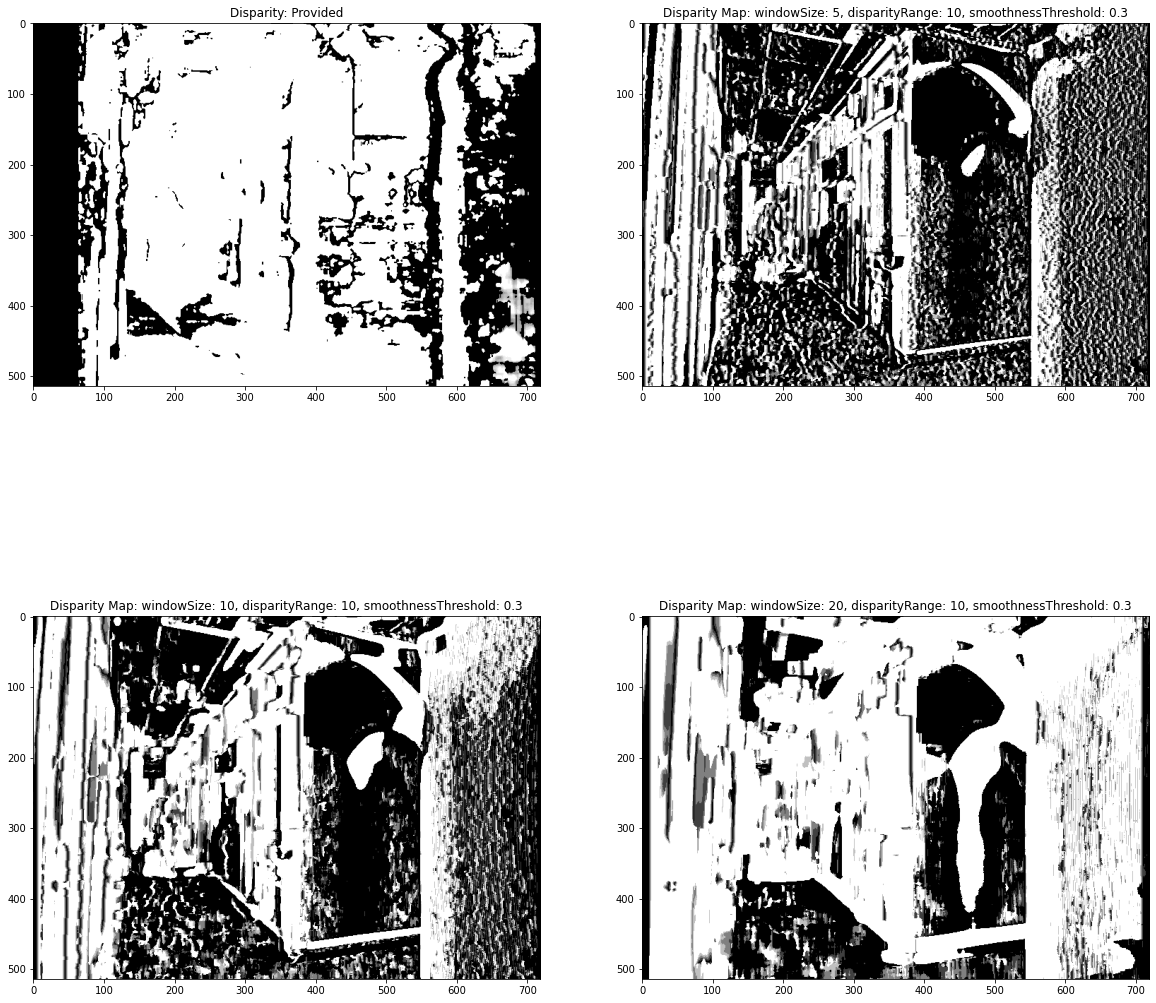

In [5]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.title("Disparity: Provided")
# plt.imshow(imgDisparity)
plt.imshow(imgDisparityControl, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Disparity Map: windowSize: 5, disparityRange: 10, smoothnessThreshold: 0.3")
# plt.imshow(imgDisparity)
plt.imshow(imgDisparity1, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Disparity Map: windowSize: 10, disparityRange: 10, smoothnessThreshold: 0.3")
# plt.imshow(imgDisparity)
plt.imshow(imgDisparity3, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Disparity Map: windowSize: 20, disparityRange: 10, smoothnessThreshold: 0.3")
# plt.imshow(imgDisparity)
plt.imshow(imgDisparity5, cmap='gray')

In [6]:
imgDisparity3_LR = imgDisparity1
imgDisparity3_RL = disparityMap(imgRight, imgLeft, searchWindowSize = 5, disparityRange = 10, smoothnessThreshold = 0.3)

In [7]:
np.max(imgDisparity3_LR.dtype), np.max(imgDisparity3_RL.dtype)

(dtype('float32'), dtype('float32'))

# Task 4: Generate outlier map - completed

In [11]:

# Call np.array instead of image file. Modify later if needed.
def outlierMap(imgLR, imgRL, indexThreshold=1):
    imgOutlier = np.zeros(imgLR.shape, imgLR.dtype)
    tempAbs = np.abs(imgLR - imgRL)
    imgOutlier[tempAbs >= indexThreshold] = 1
    return imgOutlier

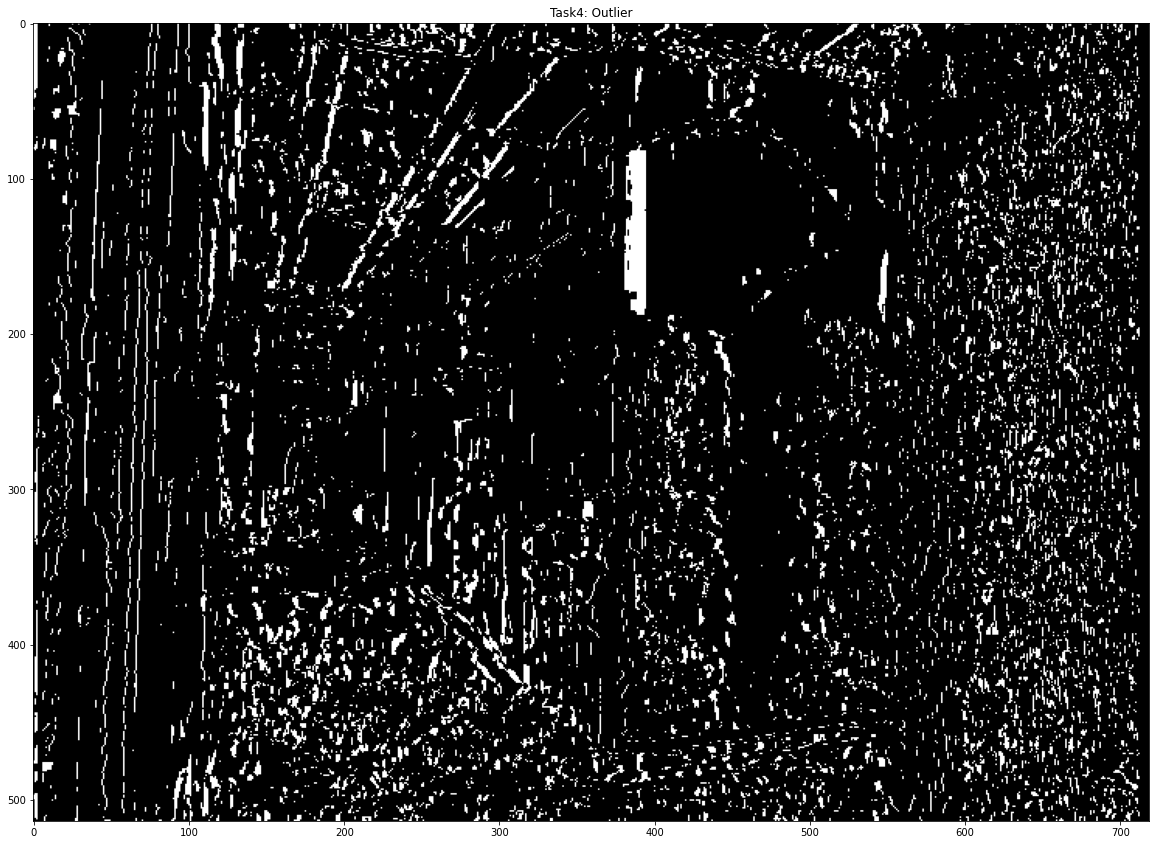

In [12]:
outlierMapImg = outlierMap(imgDisparity3_LR, imgDisparity3_RL, indexThreshold=1)

plt.figure(figsize=(20, 20))
plt.title("Task4: Outlier")
plt.imshow(outlierMapImg, cmap='gray')

# Task 5
## formula = $$d = f\frac{B}{Z}$$
**We know value Z from disparity Map, and should know B (baseline) and f (focal length measured in pixels). So, Depth Z is**
$$Z = f\frac{B}{d}$$
**From the equation above, key is finding the values, and convert values to have the same unit(mm or m ...). How to convert pixel info to this length info?**

**Update**
From the website: 
https://www.flir.com/support-center/iis/machine-vision/knowledge-base/how-is-depth-determined-from-a-disparity-image/

Maybe I don't need considering unit conversion from pixels to length(mm or m) if variables units are following. Diviging focal length by disparity, Z and B has the same unit
Z = distance along the camera Z axis
f = focal length (in pixels)
B = baseline (in metres)
d = disparity (in pixels)

In [34]:
import scipy.io
parameters = scipy.io.loadmat('./stereoParams_py.mat')

In [35]:
parameters

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Feb 26 22:23:54 2021',
 '__version__': '1.0',
 '__globals__': [],
 'CameraParameters1_EstimateSkew': array([[0]], dtype=uint8),
 'CameraParameters1_EstimateTangentialDistortion': array([[0]], dtype=uint8),
 'CameraParameters1_FocalLength': array([[530.34631942, 528.75290477]]),
 'CameraParameters1_ImageSize': array([], shape=(0, 2), dtype=uint8),
 'CameraParameters1_IntrinsicMatrix': array([[530.34631942,   0.        ,   0.        ],
        [  0.        , 528.75290477,   0.        ],
        [316.89344807, 234.5533553 ,   1.        ]]),
 'CameraParameters1_Intrinsics': array([], shape=(0, 0), dtype=uint8),
 'CameraParameters1_MeanReprojectionError': array([[0.21723935]]),
 'CameraParameters1_NumPatterns': array([[12]], dtype=uint8),
 'CameraParameters1_NumRadialDistortionCoefficients': array([[2]], dtype=uint8),
 'CameraParameters1_PrincipalPoint': array([[316.89344807, 234.5533553 ]]),
 'CameraParameters1_Radial

# Task 6